# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [689]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [690]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [691]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [692]:
df_offers.merge(df_transactions).shape

(324, 9)

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [693]:
#your turn

# pivoting the transactions to make unique customers as rows and the offers they accepted as features
# this will help in finding the clusters of closely related customers or find patterns in customer behaviour
pivot_transactions = df_transactions.pivot_table(index='customer_name', 
                                                  columns='offer_id',values='n').fillna(0).reset_index()

print('Shape of pivoted transactions: ',pivot_transactions.shape, '\n')
print(pivot_transactions.head())

Shape of pivoted transactions:  (100, 33) 

offer_id customer_name    1    2    3    4    5    6    7    8    9 ...    23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   

offer_id   24   25   26   27   28   29   30   31   32  
0         0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
1         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2         1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 33 columns]


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [694]:
# your turn

# Lesser values of SS would be better because that would mean the clusters are closely bound. 
# But we can't make SS=0 because that would reduce the cluster data points to a single data point. 
# And the number of clusters would be equal to the number of data points. That defeats the whole purpose.
# So a reasonable small value of K where SS is quite small is ideal. 
# We can plot K vs SS data and can find such value at the elbow of the line. 
# It is the point where further increase in K wouldn't decrease SS by significant amount.

In [695]:
customers = pivot_transactions['customer_name']

In [696]:
# take out all features representing the offers
x_cols = pivot_transactions[pivot_transactions.columns[1:]]
x_cols.shape

(100, 32)

In [697]:
# apply KMeans with different cluster sizes
from sklearn.cluster import KMeans

k_ss = {}
for k in range(2,11):
    model = KMeans(n_clusters=k,random_state=42)
    model.fit_predict(x_cols)
    # get SS for each K
    k_ss[k] = model.inertia_
k_ss

{2: 251.46031746031744,
 3: 228.31055068226121,
 4: 216.95436507936506,
 5: 203.76651387827857,
 6: 195.38591269841268,
 7: 187.12400779045515,
 8: 178.82063492063492,
 9: 171.77997835497837,
 10: 164.79231601731601}

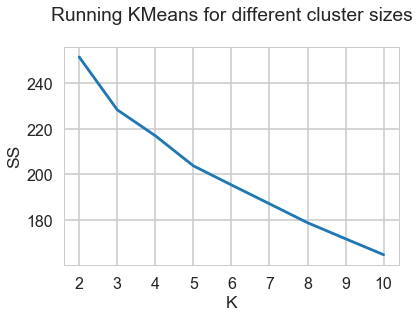

In [698]:
# plot K vs SS to find out the optimum K at elbow

import matplotlib.pyplot as plt

plt.plot(k_ss.keys(),k_ss.values())
plt.xlabel('K')
plt.ylabel('SS')
plt.xticks(list(k_ss.keys()))
plt.title('Running KMeans for different cluster sizes\n')
plt.show()



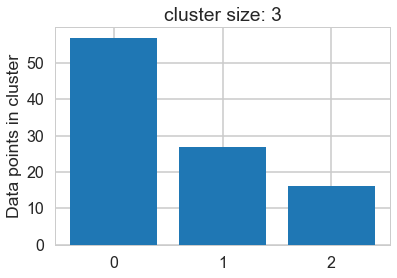

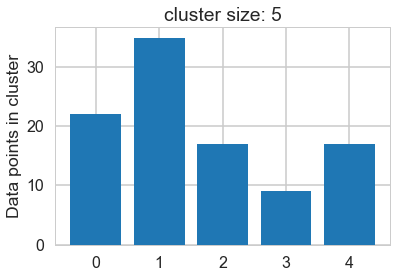

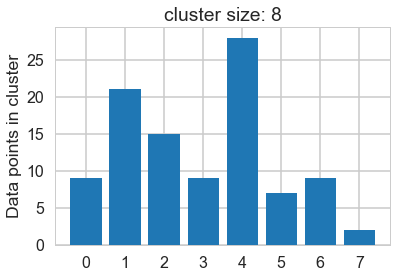

In [699]:
# The curve above doesn't have a clear elbow. Hence its hard to choose an optimum value for K.
# So it seems further analysis would be needed to find K. 
# Generally 2 things can guide here: [1] Business problem may indicate a range for K. [2] Size of data points.
# Keeping these in mind and looking at multiple elbows of the curve, K can 3, 5 or 8

for k in [3, 5, 8]:

    model = KMeans(n_clusters=k,random_state=42)
    labels = model.fit_predict(x_cols)
    clusters = pd.Series(labels).value_counts()

    plt.bar(clusters.index,clusters.values)
    plt.ylabel('Data points in cluster')
    plt.title('cluster size: '+ str(k))
    plt.xticks(clusters.index)
    plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.0917487150875


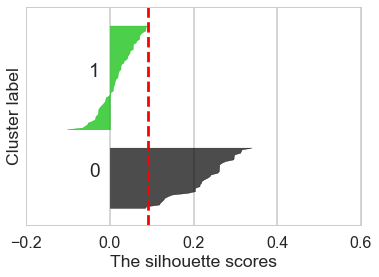

For n_clusters = 3 The average silhouette_score is : 0.115424070379


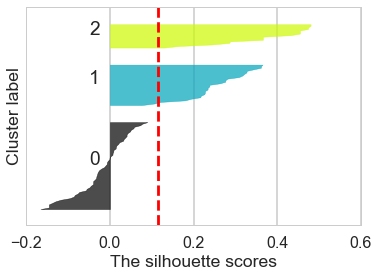

For n_clusters = 4 The average silhouette_score is : 0.0967025836069


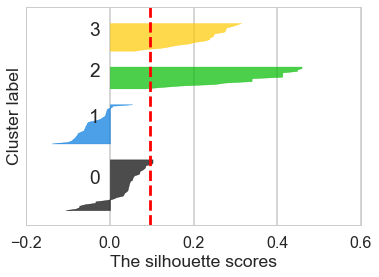

For n_clusters = 5 The average silhouette_score is : 0.145315688203


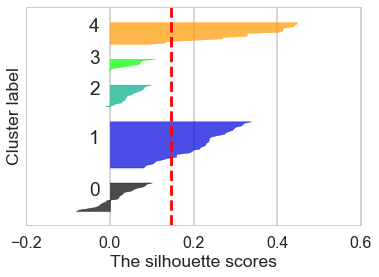

For n_clusters = 6 The average silhouette_score is : 0.133131266271


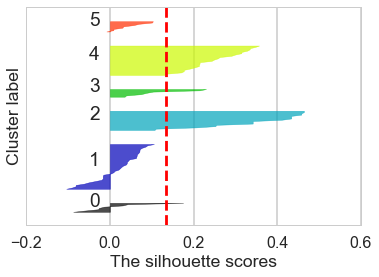

For n_clusters = 7 The average silhouette_score is : 0.130739507718


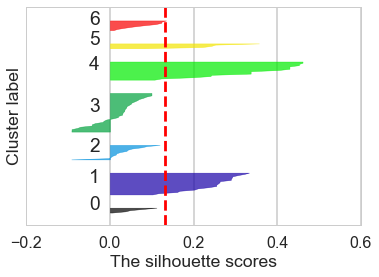

For n_clusters = 8 The average silhouette_score is : 0.123975729011


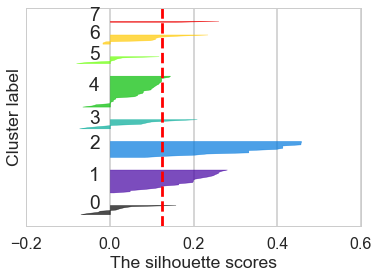

For n_clusters = 9 The average silhouette_score is : 0.120246511094


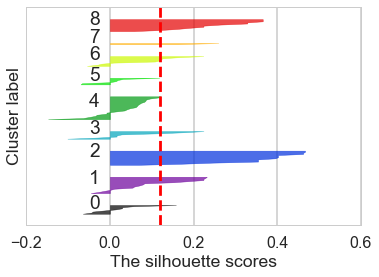

For n_clusters = 10 The average silhouette_score is : 0.126951431234


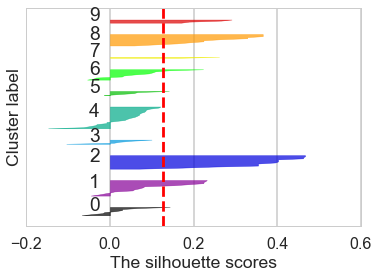

In [700]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = x_cols
avgSilScoresForK = {}

for n_clusters in range(2,11):
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.2, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    avgSilScoresForK[n_clusters] = silhouette_avg
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette scores")
    plt.ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([ -0.2, 0, 0.2, 0.4, 0.6])  

    plt.show()

In [701]:
# custer size vs average silhouette score
avgSilScoresForK

{2: 0.091748715087503513,
 3: 0.11542407037894219,
 4: 0.096702583606931222,
 5: 0.14531568820332333,
 6: 0.13313126627114877,
 7: 0.13073950771832585,
 8: 0.12397572901124844,
 9: 0.1202465110942483,
 10: 0.12695143123424532}

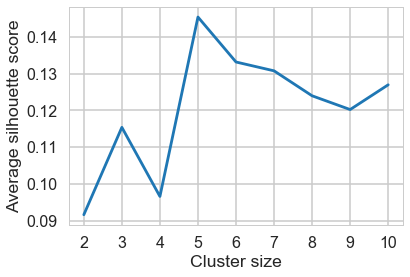

In [702]:
# plot avg silhouette scores
plt.plot(avgSilScoresForK.keys(),avgSilScoresForK.values())
plt.xticks(list(avgSilScoresForK.keys()))
plt.xlabel('Cluster size')
plt.ylabel('Average silhouette score')
plt.show()

In [703]:
# All silhuoette scores are < 0.25 and it suggests that there is No substantial structure been found.
# However comparing scores for different Ks tells that K=5 might be optimum.

# So both the methods, Elbow and Silhouette agree with K=5 if there is any pattern at all in the data.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [718]:
# number of clusters 
k=5
model = KMeans(n_clusters=k,random_state=42)
labels = pd.Series(model.fit_predict(x_cols),name='cluster')

df = pd.concat([x_cols,labels],axis=1)
#print(df.head())

cluster_offers = {}
df = df.groupby('cluster').sum()>0

# offers in each cluster    
for num in range(0,k):    
    cls = df.iloc[num]
    cluster_offers[num] = list(cls[cls.iloc[:]==True].index)
    print('offers in cluster(',num, ') are:',cluster_offers[num])


offers in cluster( 0 ) are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32]
offers in cluster( 1 ) are: [3, 6, 7, 8, 10, 11, 12, 13, 18, 21, 27, 28, 29, 30]
offers in cluster( 2 ) are: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 18, 19, 21, 22, 25, 27, 28, 30, 31, 32]
offers in cluster( 3 ) are: [1, 4, 5, 6, 9, 10, 11, 14, 15, 20, 22, 23, 25, 26, 30, 31]
offers in cluster( 4 ) are: [1, 2, 10, 12, 16, 17, 23, 24, 26, 27]


In [719]:
offers_dict = {}
varieties = {}
campaingns = {}
qtys = {}
origins = {}
for i in range(0,k):
    offers_dict[i] = df_offers[df_offers['offer_id'].isin(cluster_offers[i])]
    varieties[i] = set(offers_dict[i]['varietal'])
    campaingns[i] = set(offers_dict[i]['campaign'])
    qtys[i] = set(offers_dict[i].iloc[:,3])
    origins[i] = set(offers_dict[i].iloc[:,5])

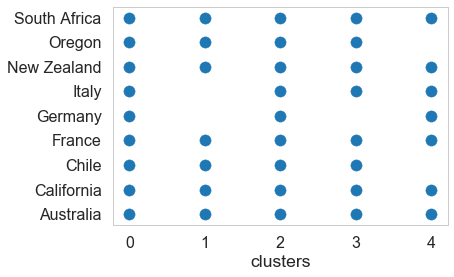

In [706]:
def draw_relation(data,feature):
    relation = []
    for cls,v in data.items():
        for ix,item in enumerate(v):
            relation.append({feature:item,'cluster':cls})
    relation_df = pd.DataFrame(relation)
    plt.scatter(x=relation_df['cluster'], y=relation_df[feature])
    plt.xticks([0,1,2,3,4])
    plt.xlabel('clusters')
    plt.grid(False)
    
draw_relation(origins,'country')

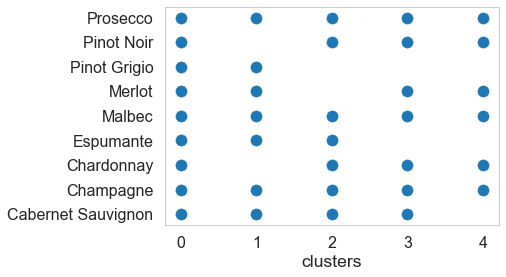

In [707]:
draw_relation(varieties,'varietal')

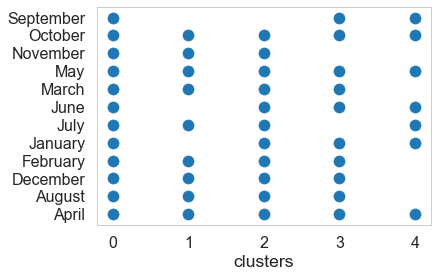

In [708]:
draw_relation(campaingns,'campaingn')

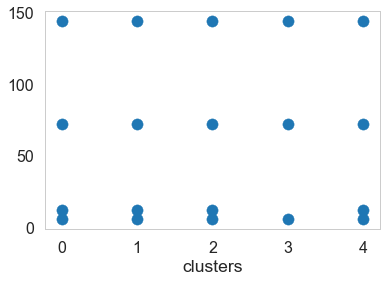

In [709]:
draw_relation(qtys,'quantity')

All the above graphs don't indicate any feature that is strongly associated with different clusters may it be wine varietal or campaign month or origin country.

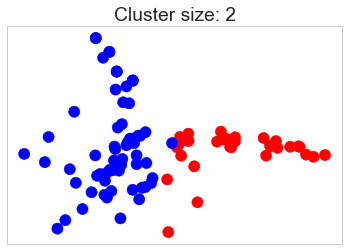

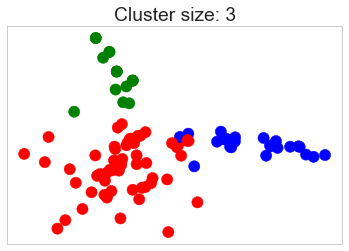

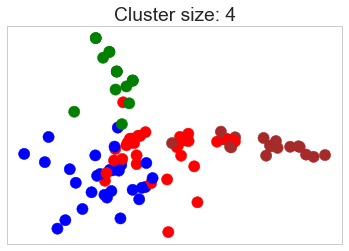

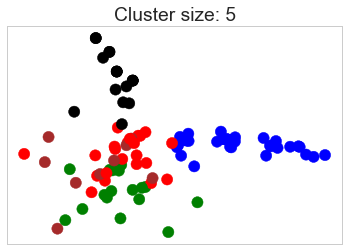

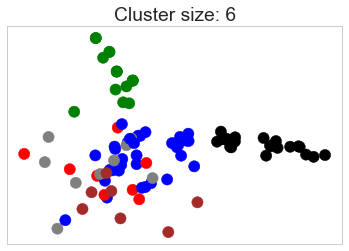

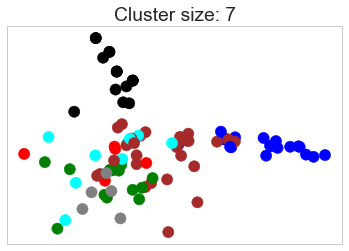

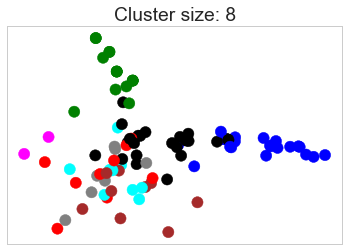

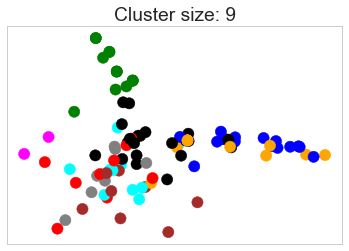

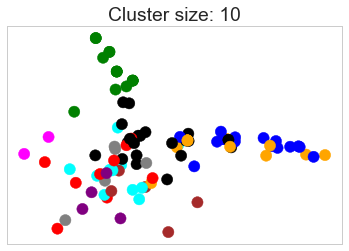

In [710]:
#your turn
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)
    
for n_clusters in range(2,11):
    model = KMeans(n_clusters=n_clusters,random_state=42)
    labels = model.fit_predict(x_cols)
    clusters = pd.Series(labels).value_counts()

    principalComponents = pca.fit_transform(x_cols)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['x', 'y'])

    labels = pd.Series(labels,name='cluster')

    df = pd.concat([customers, principalDf, labels], axis=1)
    colors = ['red','blue','green','brown','black','gray','cyan','magenta','orange','purple']

    for i in range(0,n_clusters):
        df.loc[df['cluster'] == i, 'color'] = colors[i]

    plt.title('Cluster size: ' + str(n_clusters))
    plt.scatter(x=principalDf['x'],y=principalDf['y'],color=list(df['color']))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

[ 0.4096489   0.30753551  0.2022926   0.16703717  0.15015248  0.1434373
  0.13818887  0.12192294  0.11636172  0.10804271  0.09937813  0.09495961
  0.08690352  0.07256738  0.0660996   0.06245473  0.05634388  0.05327395
  0.04728801  0.04393911  0.03900424  0.03625783  0.03455714  0.03235091
  0.02940632  0.02618221  0.02308167  0.02142632  0.018814    0.0165252
  0.01426187  0.0077789 ]


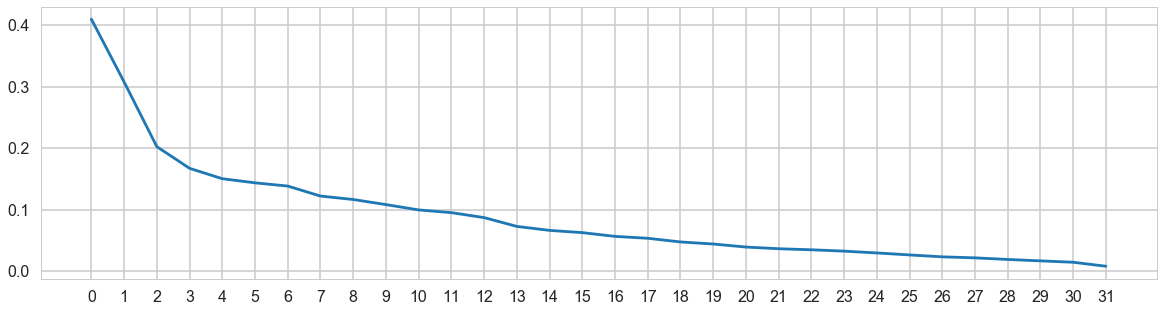

In [711]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
features = range(pca.n_components_)
print(pca.explained_variance_)

# Do the rest on your own :)
plt.rcParams["figure.figsize"] =(20,5) 
plt.plot(features,pca.explained_variance_,)
plt.xticks(features)
plt.show()

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [712]:
# Your turn
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
labels = ap.fit_predict(x_cols)

ap_sil_avg = silhouette_score(X, labels)
print('silhouette score for default params: ',ap_sil_avg)
print('number of clusters: ',len(ap.cluster_centers_indices_))

silhouette score for default params:  0.123465236045
number of clusters:  14


In [713]:
from sklearn.cluster import SpectralClustering
best_sil_avg=0

for k in range(2,11):
    ac = SpectralClustering(n_clusters=k)
    labels = ac.fit_predict(x_cols)
    sc_sil_avg = silhouette_score(X, labels)
    
    best_sil_avg = max(sc_sil_avg,best_sil_avg)
    print('silhouette score for k=',k,'is: ', sc_sil_avg)
    
print('best silhouette score', best_sil_avg )

silhouette score for k= 2 is:  0.0591405970172
silhouette score for k= 3 is:  0.0999059123102
silhouette score for k= 4 is:  0.0290656989328
silhouette score for k= 5 is:  0.0158567687769
silhouette score for k= 6 is:  0.0175823270868
silhouette score for k= 7 is:  0.0526931828711
silhouette score for k= 8 is:  0.0572454782216
silhouette score for k= 9 is:  0.0616746850726
silhouette score for k= 10 is:  0.0187358137264
best silhouette score 0.0999059123102


In [714]:
from sklearn.cluster import AgglomerativeClustering
best_sil_avg=0

for k in range(2,11):
    ac = AgglomerativeClustering(n_clusters=k)
    labels = ac.fit_predict(x_cols)
    ac_sil_avg = silhouette_score(X, labels)
    
    best_sil_avg = max(ac_sil_avg,best_sil_avg)    
    print('silhouette score for k=',k,'is: ', ac_sil_avg)
    
print('best silhouette score', best_sil_avg )

silhouette score for k= 2 is:  0.0825801782318
silhouette score for k= 3 is:  0.116258788636
silhouette score for k= 4 is:  0.128937578159
silhouette score for k= 5 is:  0.140897399708
silhouette score for k= 6 is:  0.147152172046
silhouette score for k= 7 is:  0.152751527511
silhouette score for k= 8 is:  0.155780537186
silhouette score for k= 9 is:  0.12075124132
silhouette score for k= 10 is:  0.0975475074715
best silhouette score 0.155780537186


In [715]:
from sklearn.cluster import DBSCAN
best_sil_avg=0

for min_sample in [1,2,3]:
    db = DBSCAN(min_samples=min_sample)
    labels = db.fit_predict(x_cols)
    db_sil_avg = silhouette_score(X, labels)
    
    best_sil_avg = max(db_sil_avg,best_sil_avg)
    print('silhouette score for min_samples=',min_sample,'is: ', db_sil_avg)
    
print('best silhouette score', best_sil_avg )

silhouette score for min_samples= 1 is:  0.19
silhouette score for min_samples= 2 is:  -0.0216780594814
silhouette score for min_samples= 3 is:  -0.106635558255
best silhouette score 0.19


None of the algorithms performed good. As we can see all the silhouette scores are less than 0.2 and hence not significant. And all give different value K for number of clusters.

Overall, the given data set doesn't have enough signal. It doesn't give any clear pattern among the customer behaviour. However, after analyzing with different algorithm and trying out different cluster sizes. It looks that cluster size of 3 may be present. PCA and KMeans together indicate 3 clusters as optimum. Given more data we can prove or disprove that.